In [1]:
# Web Data → Wrangle → Visualize ===
# Dataset: Open Brewery DB (public, no key)
# Author: Jonathan Snyder
# Date: 11/6/25

import os, json, math, textwrap, itertools, time
from pathlib import Path

import numpy as np
import pandas as pd
import requests

import matplotlib.pyplot as plt
import seaborn as sns

# Project folders
ROOT = Path.cwd()
DATA_DIR = ROOT / "data"
IMG_DIR  = ROOT / "images"
DATA_DIR.mkdir(exist_ok=True)
IMG_DIR.mkdir(exist_ok=True)

RAW_JSON = DATA_DIR / "raw.json"
RAW_CSV  = DATA_DIR / "raw.csv"
CLEANED_CSV = DATA_DIR / "cleaned.csv"


# Q1. DATA COLLECTION

def fetch_openbrewery(max_pages=8, per_page=200, pause=0.4):
    """
    Pull breweries from Open Brewery DB.
    - No API key / no login
    - Pagination supported: up to ~8*200=1600 rows (tweak as you like)
    """
    all_rows = []
    base = "https://api.openbrewerydb.org/v1/breweries"
    for page in range(1, max_pages+1):
        url = f"{base}?per_page={per_page}&page={page}"
        r = requests.get(url, timeout=30)
        r.raise_for_status()
        rows = r.json()
        if not rows:
            break
        all_rows.extend(rows)
        time.sleep(pause)  # be polite
    return all_rows

# data
rows = fetch_openbrewery(max_pages=8, per_page=200)

# Save raw.json
with open(RAW_JSON, "w", encoding="utf-8") as f:
    json.dump(rows, f, ensure_ascii=False, indent=2)

# Save raw.csv convenience
raw_df = pd.json_normalize(rows)
raw_df.to_csv(RAW_CSV, index=False)

print(f"[Q1] Saved {len(raw_df):,} rows to:\n- {RAW_JSON}\n- {RAW_CSV}")



[Q1] Saved 1,600 rows to:
- C:\Users\jonnypc\Downloads\brewerydata_scrape\data\raw.json
- C:\Users\jonnypc\Downloads\brewerydata_scrape\data\raw.csv


In [2]:
# Q2. DATA WRANGLING

# Load raw
df = pd.read_json(RAW_JSON)

print("\n[Q2] df.info() BEFORE cleaning:")
df.info()

# ---- Cleaning steps ----
# 1) Standardize string whitespace/case on selected columns
str_cols = ["name", "brewery_type", "street", "city", "state", "country", "website_url"]
for c in str_cols:
    if c in df.columns:
        df[c] = df[c].astype("string").str.strip()

# Lowercase brewery_type
df["brewery_type"] = df["brewery_type"].str.lower()

# 2) Standardize missing values: turn empty strings to NaN
df = df.replace({"": np.nan, "na": np.nan, "n/a": np.nan, "None": np.nan})

# 3) Convert numeric columns
for num_col in ["latitude", "longitude"]:
    if num_col in df.columns:
        df[num_col] = pd.to_numeric(df[num_col], errors="coerce")

# 4) Handle duplicates
dedup_key = "id" if "id" in df.columns else ["name", "city", "state"]
before = len(df)
df = df.drop_duplicates(subset=dedup_key, keep="first")
after = len(df)
print(f"\nRemoved duplicates: {before - after}")

# 5) Handle missing values
# Example: if state missing but country is US, try to keep; otherwise keep NaN.
# We'll drop rows missing critical geolocation for mapping/relationship plot (lat/long) later when needed.
missing_summary_before = df.isna().mean().sort_values(ascending=False).head(8)
print("\nTop missingness BEFORE fill/drop:\n", missing_summary_before)

# Minimal impute
df["brewery_type"] = df["brewery_type"].fillna("unknown")

# 6) Derived metric
df["name_len"] = df["name"].str.len()
df["is_micro"] = (df["brewery_type"] == "micro").astype(int)

# 7) Binned variable
state_counts = df.groupby("state", dropna=False)["id" if "id" in df.columns else "name"].count().rename("state_total")
df = df.merge(state_counts, left_on="state", right_index=True, how="left")

# Quantile bin
df["state_size_bin"] = pd.qcut(df["state_total"].fillna(0), q=4, labels=["low", "med-low", "med-high", "high"])

# 8) Groupby + agg (mean, max) & share within group using transform
gb = df.groupby(["state", "brewery_type"], dropna=False).agg(
    breweries=("id" if "id" in df.columns else "name", "count"),
    avg_name_len=("name_len", "mean"),
    max_name_len=("name_len", "max")
).reset_index()

# share within state = breweries / sum(breweries) per state
gb["state_total"] = gb.groupby("state")["breweries"].transform("sum")
gb["type_share_in_state"] = gb["breweries"] / gb["state_total"]

# 9) Pivot table and equivalent groupby-unstack. maatch
pivot = pd.pivot_table(
    df,
    index="state",
    columns="brewery_type",
    values=("id" if "id" in df.columns else "name"),
    aggfunc="count",
    fill_value=0
)

group_unstack = (df
    .groupby(["state", "brewery_type"])
    .size()
    .unstack(fill_value=0)
)

# Check for equality
pivot_equal = pivot.equals(group_unstack)
print(f"\nPivot vs groupby.unstack equal? {pivot_equal}")

# Save cleaned dataset
df.to_csv(CLEANED_CSV, index=False)
print(f"\n[Q2] Cleaned dataset saved to: {CLEANED_CSV}")

print("\n[Q2] df.info() AFTER cleaning:")
df.info()

# small sample
display(df.head(10))




[Q2] df.info() BEFORE cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1600 non-null   object 
 1   name            1600 non-null   object 
 2   brewery_type    1600 non-null   object 
 3   address_1       1480 non-null   object 
 4   address_2       42 non-null     object 
 5   address_3       6 non-null      object 
 6   city            1600 non-null   object 
 7   state_province  1600 non-null   object 
 8   postal_code     1600 non-null   object 
 9   country         1600 non-null   object 
 10  longitude       1208 non-null   float64
 11  latitude        1208 non-null   float64
 12  phone           1435 non-null   object 
 13  website_url     1351 non-null   object 
 14  state           1600 non-null   object 
 15  street          1480 non-null   object 
dtypes: float64(2), object(14)
memory usage: 200.1

,id,name,brewery_type,address_1,address_2,address_3,city,state_province,postal_code,country,longitude,latitude,phone,website_url,state,street,name_len,is_micro,state_total,state_size_bin
0,5128df48-79fc-4f0f-8b52-d06be54d0cec,(405) Brewing Co,micro,1716 Topeka St,None,None,Norman,Oklahoma,73069-8224,United States,-97.468182,35.257389,4058160490,http://www.405brewing.com,Oklahoma,1716 Topeka St,16,1,12,low
1,9c5a66c8-cc13-416f-a5d9-0a769c87d318,(512) Brewing Co,micro,407 Radam Ln Ste F200,None,None,Austin,Texas,78745-1197,United States,NaN,NaN,5129211545,http://www.512brewing.com,Texas,407 Radam Ln Ste F200,16,1,71,med-high
2,34e8c68b-6146-453f-a4b9-1f6cd99a5ada,1 of Us Brewing Company,micro,8100 Washington Ave,None,None,Mount Pleasant,Wisconsin,53406-3920,United States,-87.883364,42.720108,2624847553,https://www.1ofusbrewing.com,Wisconsin,8100 Washington Ave,23,1,35,med-low
3,6d14b220-8926-4521-8d19-b98a2d6ec3db,10 Barrel Brewing Co,large,62970 18th St,None,None,Bend,Oregon,97701-9847,United States,-121.281706,44.086835,5415851007,http://www.10barrel.com,Oregon,62970 18th St,20,0,55,med-high
4,e2e78bd8-80ff-4a61-a65c-3bfbd9d76ce2,10 Barrel Brewing Co,large,1135 NW Galveston Ave Ste B,None,None,Bend,Oregon,97703-2465,United States,-121.328802,44.057565,5415851007,<NA>,Oregon,1135 NW Galveston Ave Ste B,20,0,55,med-high
5,e432899b-7f58-455f-9c7b-9a6e2130a1e0,10 Barrel Brewing Co,large,1411 NW Flanders St,None,None,Portland,Oregon,97209-2620,United States,-122.685506,45.525979,5032241700,http://www.10barrel.com,Oregon,1411 NW Flanders St,20,0,55,med-high
6,ef970757-fe42-416f-931d-722451f1f59c,10 Barrel Brewing Co,large,1501 E St,None,None,San Diego,California,92101-6618,United States,-117.129593,32.714813,6195782311,http://10barrel.com,California,1501 E St,20,0,161,high
7,9f1852da-c312-42da-9a31-097bac81c4c0,10 Barrel Brewing Co - Bend Pub,large,62950 NE 18th St,None,None,Bend,Oregon,97701,United States,-121.280954,44.091211,5415851007,<NA>,Oregon,62950 NE 18th St,31,0,55,med-high
8,ea4f30c0-bce6-416b-8904-fab4055a7362,10 Barrel Brewing Co - Boise,large,826 W Bannock St,None,None,Boise,Idaho,83702-5857,United States,-116.202929,43.618516,2083445870,http://www.10barrel.com,Idaho,826 W Bannock St,28,0,9,low
9,1988eb86-f0a2-4674-ba04-02454efa0d31,10 Barrel Brewing Co - Denver,large,2620 Walnut St,None,None,Denver,Colorado,80205-2231,United States,-104.985366,39.759251,7205738992,<NA>,Colorado,2620 Walnut St,29,0,72,high


[Q3] Saved plot: C:\Users\jonnypc\Downloads\brewerydata_scrape\images\plot_distribution_hist.png — Distribution (Seaborn)
[Q3] Saved plot: images/plot_relationship_scatter.png
[Q3] Saved plot: C:\Users\jonnypc\Downloads\brewerydata_scrape\images\plot_comparison_grouped_bar.png — Comparison (Matplotlib)

Submission:
 - data/raw.json
 - data/raw.csv
 - data/cleaned.csv
 - images/plot_distribution_hist.png
 - images/plot_relationship_scatter.png
 - images/plot_comparison_grouped_bar.png


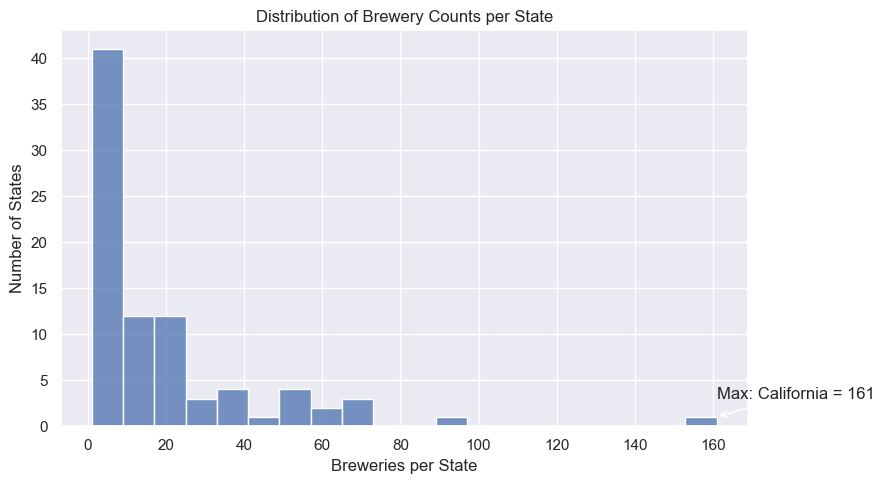

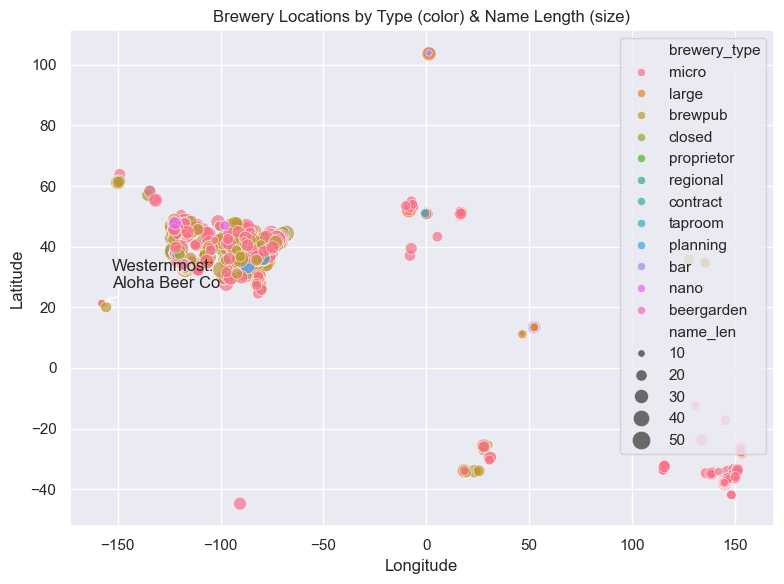

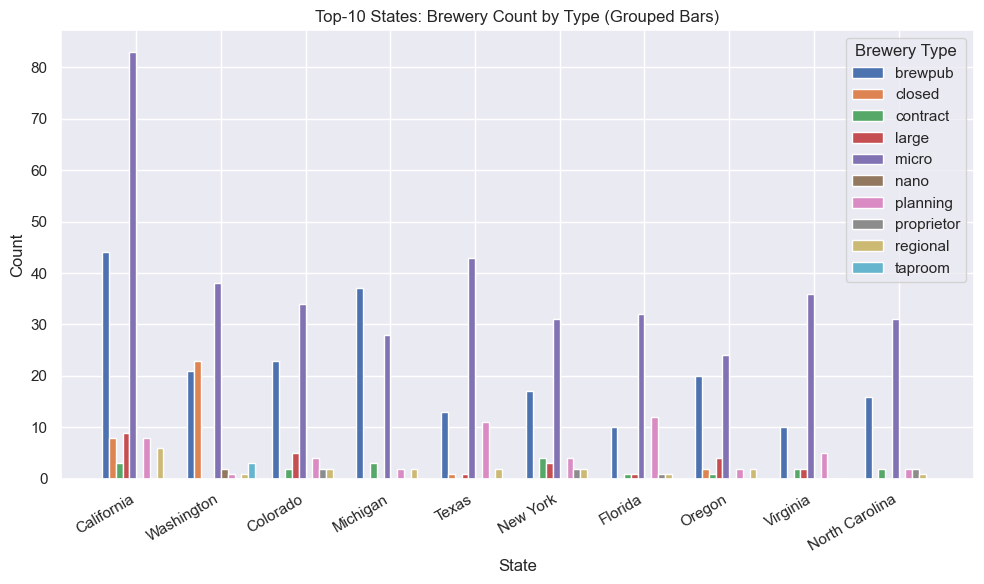

In [3]:

# Q3. VISUALIZATION

sns.set_theme()

# Helper for titles/annotations
def save_and_annotate(fig, filename, note):
    fig.tight_layout()
    out = IMG_DIR / filename
    fig.savefig(out, dpi=200, bbox_inches="tight")
    print(f"[Q3] Saved plot: {out} — {note}")

# (A) Distribution view: histogram of breweries per state
state_totals = (df.groupby("state")["name"].count()
                .rename("count")
                .reset_index()
                .dropna(subset=["state"]))

fig1, ax1 = plt.subplots(figsize=(9,5))
sns.histplot(state_totals["count"], bins=20, ax=ax1)
ax1.set_title("Distribution of Brewery Counts per State")
ax1.set_xlabel("Breweries per State")
ax1.set_ylabel("Number of States")
# annotate: show the state with max breweries
max_row = state_totals.loc[state_totals["count"].idxmax()]
ax1.annotate(
    f"Max: {max_row['state']} = {int(max_row['count'])}",
    xy=(max_row["count"], 1),
    xytext=(max_row["count"], 3),
    arrowprops=dict(arrowstyle="->")
)
save_and_annotate(fig1, "plot_distribution_hist.png", "Distribution (Seaborn)")

# (B) Relationship view
cols_needed = ["longitude", "latitude", "brewery_type", "name_len", "name"]
geo = df.loc[:, [c for c in cols_needed if c in df.columns]].copy()

# Force numeric and finite for x, y, size
for col in ["longitude", "latitude", "name_len"]:
    geo[col] = pd.to_numeric(geo[col], errors="coerce")

geo = geo.replace([np.inf, -np.inf], np.nan)
geo = geo.dropna(subset=["longitude", "latitude"])  #  valid coords needed to plot
geo["name_len"] = geo["name_len"].fillna(0).astype(float)



fig2, ax2 = plt.subplots(figsize=(8, 6))
sns.scatterplot(
    data=geo,
    x="longitude", y="latitude",
    hue="brewery_type",
    size="name_len",
    sizes=(10, 200),
    alpha=0.7,
    ax=ax2,
    legend=True
)
ax2.set_title("Brewery Locations by Type (color) & Name Length (size)")
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")

# Annotate an extreme point as outlier
west_idx = geo["longitude"].idxmin()
west_row = geo.loc[west_idx]
ax2.annotate(
    f"Westernmost:\n{west_row.get('name','(unknown)')}",
    xy=(west_row["longitude"], west_row["latitude"]),
    xytext=(west_row["longitude"] + 5, west_row["latitude"] + 5),
    arrowprops=dict(arrowstyle="->")
)

fig2.tight_layout()
fig2.savefig(IMG_DIR / "plot_relationship_scatter.png", dpi=200, bbox_inches="tight")
print("[Q3] Saved plot: images/plot_relationship_scatter.png")

# (C) Comparison view: grouped bar (Matplotlib) for Top-10 states by total
counts_by_state_type = (df.groupby(["state", "brewery_type"])
                          .size()
                          .rename("n")
                          .reset_index())
totals = counts_by_state_type.groupby("state")["n"].sum().sort_values(ascending=False)
top_states = totals.head(10).index.tolist()
top_df = counts_by_state_type[counts_by_state_type["state"].isin(top_states)]

# Pivot for grouped bars
bar_pvt = top_df.pivot(index="state", columns="brewery_type", values="n").fillna(0)
order_idx = bar_pvt.sum(axis=1).sort_values(ascending=False).index
bar_pvt = bar_pvt.loc[order_idx]


fig3, ax3 = plt.subplots(figsize=(10,6))
x = np.arange(len(bar_pvt.index))
width = 0.8 / max(1, bar_pvt.shape[1])

for i, col in enumerate(bar_pvt.columns):
    ax3.bar(x + i*width, bar_pvt[col].values, width=width, label=col)

ax3.set_xticks(x + (bar_pvt.shape[1]-1)*width/2)
ax3.set_xticklabels(bar_pvt.index, rotation=30, ha="right")
ax3.set_title("Top-10 States: Brewery Count by Type (Grouped Bars)")
ax3.set_xlabel("State")
ax3.set_ylabel("Count")
ax3.legend(title="Brewery Type")

# Annotate single tallest bar
max_state = bar_pvt.sum(axis=1).idxmax()
y_max = bar_pvt.loc[max_state].max()
x_max = list(bar_pvt.index).index(max_state)
ax3.annotate(
    f"Highest total: {max_state}",
    xy=(x_max, bar_pvt.loc[max_state].sum()),
    xytext=(x_max, bar_pvt.loc[max_state].sum()+10),
    ha="center",
    arrowprops=dict(arrowstyle="->")
)
save_and_annotate(fig3, "plot_comparison_grouped_bar.png", "Comparison (Matplotlib)")

print("\nSubmission:")
print(" - data/raw.json")
print(" - data/raw.csv")
print(" - data/cleaned.csv")
print(" - images/plot_distribution_hist.png")
print(" - images/plot_relationship_scatter.png")
print(" - images/plot_comparison_grouped_bar.png")